## Imports

In [14]:
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from jax import random

import equinox as eqx
import optax

import numpyro.distributions as dist

from IPython.display import clear_output

from typing import List, Tuple
from jaxtyping import Int, Array, Float, PyTree

/home/scivier/Documents/neural-process-example/venv-npexample/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Defining classes and functions

### Models

In [15]:
# Defining the MLP model, to be used as a batch MLP
# Inherit the eqx.Module class

class MLP(eqx.Module):

    layers: List

    def __init__(
        self,
        layer_sizes: List,
        key: jax.random.PRNGKey,
    ):

        self.layers = []

        for (feat_in, feat_out) in zip(layer_sizes[:-2], layer_sizes[1:-1]):
            key, subkey = random.split(key)

            self.layers.append(
                eqx.nn.Linear(feat_in, feat_out, use_bias=True, key=subkey)
            )  # fully-connected layer
            self.layers.append(
                jnp.tanh
            )  # activation function

        key, subkey = random.split(key)

        self.layers.append(
            eqx.nn.Linear(layer_sizes[-2], layer_sizes[-1], use_bias=True, key=subkey)
        )  # final layer

    # __call__ turns an instance of this class into a callable object, which behaves like a function
    def __call__(
        self,
        x: Float[Array, "1 1"],
    ) -> Float[Array, "1 1"]:

        # apply each layer in sequence
        for layer in self.layers:
            x = layer(x)

        return x

In [53]:
def generate_architecture_input():
    """
    Generate architecture input for the ConvNet class based on user input.

    Returns:
    --------
    List[Dict]
        List containing dictionaries describing the architecture of the model.
    """
    architecture = []
    while True:
        layer = {}
        print("Add a new layer:")
        layer_type = input("Enter layer type (conv/linear) or press Enter to finish: ").strip().lower()
        if layer_type == '':
            if not architecture or 'linear' not in architecture[-1]:  # Check if the last layer is linear
                print("The last layer must be linear.")
                continue
            else:
                break
        elif layer_type not in ['conv', 'linear']:
            print("Invalid layer type. Please enter 'conv' or 'linear'.")
            continue

        if layer_type == 'conv':
            if not architecture or 'conv' not in architecture[-1]:  # First convolutional layer
                in_features = architecture[-1]['linear']['out_features'] if 'linear' in architecture[-1] else 28  # Use the output features of the previous linear layer as input size
                in_channels = 1  # Number of input channels is 1
            elif 'pool' in architecture[-1]:  # Most recent layer is pooling layer
                in_channels = architecture[-1]['conv']['out_channels']  # Number of input channels is the previous layer's output channels
                in_features = architecture[-1]['pool']['out_size']  # Input size is the previous layer's output size
            else:  # Most recent layer is convolutional layer
                in_channels = architecture[-1]['conv']['out_channels']  # Number of input channels is the previous layer's output channels
                in_features = architecture[-1]['conv']['out_size']  # Input size is the previous layer's output size
            out_channels = int(input("Enter number of output channels: "))
            kernel_size = int(input("Enter kernel size: "))
            stride = int(input("Enter stride: "))
            out_size = ((in_features - kernel_size) // stride) + 1
            layer['conv'] = {
                'in_channels': in_channels,
                'out_channels': out_channels,
                'kernel_size': kernel_size,
                'stride': stride,
                'out_size': out_size
            }
            add_pooling = input("Add pooling layer (yes/no): ").strip().lower()
            if add_pooling == 'yes':
                pool_kernel_size = int(input("Enter pooling kernel size: "))
                pool_stride = int(input("Enter pooling stride: "))
                out_size = ((out_size - pool_kernel_size) // pool_stride) + 1
                layer['pool'] = {
                    'kernel_size': pool_kernel_size,
                    'stride': pool_stride,
                    'out_size': out_size
                }
        else:  # Linear layer
            if not architecture:  # First linear layer
                in_features = int(input("Enter number of input features: "))
            elif 'linear' in architecture[-1]:  # Following another linear layer
                in_features = architecture[-1]['linear']['out_features']  # Number of input features is the previous layer's output features
            else:  # Following a convolutional block
                in_channels = architecture[-1]['conv']['out_channels']
                if 'pool' in architecture[-1]:
                    out_channels = architecture[-1]['conv']['out_channels']
                    out_size = architecture[-1]['pool']['out_size']
                else:
                    out_channels = architecture[-1]['conv']['out_channels']
                    out_size = architecture[-1]['conv']['out_size']
                in_features = out_channels * out_size
            out_features = int(input("Enter number of output features: "))
            layer['linear'] = {
                'in_features': in_features,
                'out_features': out_features
            }

        architecture.append(layer)

    return architecture


In [31]:
class ConvNet(eqx.Module):

    linear_1: eqx.nn.Linear
    linear_2: eqx.nn.Linear
    linear_3: eqx.nn.Linear
    conv_1: eqx.nn.Conv
    conv_2: eqx.nn.Conv
    pool_1: eqx.nn.MaxPool1d
    pool_2: eqx.nn.MaxPool1d
    activation: callable

    def __init__(
        self,
        outer_layers: List,
        key: jax.random.PRNGKey,
    ):
        
        key, *subkeys = random.split(key, 6)
        
        self.linear_1 = eqx.nn.Linear(
            in_features=outer_layers[0], 
            out_features=64,
            key=subkeys[0],
        )
        self.conv_1 = eqx.nn.Conv(
            num_spatial_dims=1,
            in_channels=1,
            out_channels=16,
            kernel_size=3,
            key=subkeys[1],
        )
        self.pool_1 = eqx.nn.MaxPool1d(
            kernel_size=2,
            stride=2,
        )
        self.conv_2 = eqx.nn.Conv(
            num_spatial_dims=1,
            in_channels=16,
            out_channels=32,
            kernel_size=3,
            key=subkeys[2],
        )
        self.pool_2 = eqx.nn.MaxPool1d(
            kernel_size=2,
            stride=2,
        )
        self.linear_2 = eqx.nn.Linear(
            in_features=448,
            out_features=128,
            key=subkeys[3],
        )
        self.linear_3 = eqx.nn.Linear(
            in_features=128,
            out_features=outer_layers[1],
            key=subkeys[4],
        )

        self.activation = jnp.tanh

    # __call__ turns an instance of this class into a callable object, which behaves like a function
    def __call__(
        self,
        x: Float[Array, "1 1"],
    ) -> Float[Array, "1 1"]:

        # apply each layer in sequence
        x = self.activation(self.linear_1(x))
        x = jnp.expand_dims(x, axis=0)
        x = self.activation(self.conv_1(x))
        print(x.shape)
        x = self.pool_1(x)
        print(x.shape)
        x = self.activation(self.conv_2(x))
        print(x.shape)
        x = self.pool_2(x)
        print(x.shape)
        x = x.flatten()
        print(x.shape)
        x = self.activation(self.linear_2(x))
        x = self.linear_3(x)

        return x

In [32]:
class CNP(eqx.Module):

    layers: list

    def __init__(
            self,
            encoder: MLP,
            decoder: MLP,
    ):

        self.layers = [encoder, decoder]


    def __call__(
            self,
            x_context: Float[Array, "batch n_context 1"],
            y_context: Float[Array, "batch n_context 1"],
            x_target: Float[Array, "batch n_target 1"],
    ) -> dist.Distribution:

        # get number of target points
        _, n_target, _ = x_target.shape

        # encoder step
        encoded_rep = self._encode(x_context, y_context)  # (batch_size, 1, encoder_dim)

        # tile sample before passing to the decoder
        representation = self._tile(encoded_rep, n_target)  # (batch_size, n_target, encoder_dim)

        # decoder step to produce distribution of functions
        distribution = self._decode(representation, x_target)

        return distribution


    def _encode(
            self,
            x_context: Float[Array, "batch n_context 1"],
            y_context: Float[Array, "batch n_context 1"],
    ) -> dist.Distribution:

        xy_context = jnp.concatenate([x_context, y_context], axis=-1)  # (batch_size, n_context, 2)

        return jnp.mean(self._encode_mlp(xy_context), axis=1, keepdims=True)  # (batch_size, 1, encoder_dim)


    def _encode_mlp(
            self,
            xy_context: Float[Array, "batch n_context 2"],
    ) -> Float[Array, "batch n_context encoder_dim"]:

        return jax.vmap(jax.vmap(self.layers[0]))(xy_context)


    def _tile(
            self,
            z_latent: Float[Array, "batch 1 encoder_dim"],
            n_target: Int,
    ) -> Float[Array, "batch n_target encoder_dim"]:

        return jnp.tile(z_latent, [1, n_target, 1])


    def _decode(
            self,
            representation: Float[Array, "batch n_target encoder_dim"],
            x_target: Float[Array, "batch n_target 1"],
    ) -> dist.Distribution:

        representation = jnp.concatenate([representation, x_target], axis=-1)  # (batch_size, n_target, encoder_dim + 1)

        mlp_out = jax.vmap(jax.vmap(self.layers[1]))(representation)  # (batch_size, n_target, 1)

        mu, sigma = jnp.split(mlp_out, 2, axis=-1)  # each (batch_size, n_target, 1)

        sigma = 0.1 + 0.9 * jax.nn.softplus(sigma)

        return dist.Normal(loc=mu, scale=sigma)

### Data generation

In [33]:
def exponentiated_quadratic_kernel(
    x: Array,
    y: Array,
    sigma: Float=1.0,
    rho: Float=1.0,
) -> Array:

    def _exponentiated_quadratic(x, y, sigma, rho):
        x_e = jnp.expand_dims(x, 1) / rho
        y_e = jnp.expand_dims(y, 0) / rho
        d = jnp.sum(jnp.square(x_e - y_e), axis=-1)
        K = sigma * jnp.exp(-0.5 * d)
        return K

    return _exponentiated_quadratic(x, y, sigma, rho)


def sample_gp(
    key: random.PRNGKey,
    n_imgs: int,
    domain: float,
    grid_steps: int,
    rho: float,
    sigma: float,
) -> Tuple[
    Tuple[np.ndarray, np.ndarray],
    np.ndarray
    ]:

    # generate array between -pi to pi with grid_steps no. of points
    x = jnp.linspace(-domain, domain, grid_steps).reshape(
        (grid_steps, 1)
    )

    ys = []
    for _ in range(n_imgs):
        key, *subkeys = random.split(key, 3)

        K = exponentiated_quadratic_kernel(x, x, sigma, rho)

        y = random.multivariate_normal(
            subkeys[0],
            mean=jnp.zeros(grid_steps),
            cov=K + jnp.diag(jnp.ones(grid_steps)) * np.mean(np.abs(K)) * 1e-5,
        )
        ys.append(y.reshape((1, grid_steps, 1)))

    # repeat x along first axis n_imgs times
    x = np.array(jnp.tile(x, [n_imgs, 1, 1]))  # shape (n_imgs, grid_steps ** 2, 1)
    y = np.array(jnp.vstack(jnp.array(ys)))  # shape (n_imgs, grid_steps ** 2, 1)

    return x, y

In [34]:
def random_split(datasets, lengths, seed=None):
    """
    Randomly split datasets into non-overlapping new datasets.

    Args:
        datasets (tuple or list): A tuple or list of datasets to be split.
        lengths (list): A list of integers specifying the lengths of the subsets.
        seed (int, optional): Seed for the random number generator.

    Returns:
        list: A list of tuples, where each tuple contains the subsets of the input datasets.

    Example:
        >>> dataset_x = jnp.arange(100)
        >>> dataset_y = jnp.arange(100) * 2
        >>> subsets = random_split((dataset_x, dataset_y), lengths=[70, 20, 10], seed=42)
    """
    if not isinstance(datasets, (tuple, list)):
        raise ValueError("Input datasets must be a tuple or list.")

    num_datasets = len(datasets)
    if num_datasets < 1:
        raise ValueError("At least one dataset must be provided.")

    for dataset in datasets:
        if sum(lengths) != len(dataset):
            raise ValueError("Sum of lengths must equal the length of the datasets.")

    if seed is not None:
        key = random.PRNGKey(seed)
    else:
        key = random.PRNGKey(0)

    key, subkey = random.split(key)
    permuted_indices = random.permutation(subkey, len(datasets[0]))

    start = 0
    subsets = []
    for length in lengths:
        end = start + length
        subset_indices = permuted_indices[start:end]
        subset_data = []
        for dataset in datasets:
            subset = [dataset[i] for i in subset_indices]
            subset_data.append(jnp.stack(subset))
        subsets.append(tuple(subset_data))
        start = end

    return subsets

In [35]:
import jax.numpy as jnp
from jax import random

class DataLoader:
    """
    A class for creating data loaders in JAX similar to PyTorch's DataLoader.

    Args:
        datasets (tuple or list): A tuple or list of datasets to be combined.
        batch_size (int, optional): Batch size for each batch. Defaults to 1.
        shuffle (bool, optional): Whether to shuffle the data before creating batches. Defaults to False.
        seed (int, optional): Seed for the random number generator. Required if shuffle is True.

    Attributes:
        datasets (tuple or list): A tuple or list of datasets to be combined.
        batch_size (int): Batch size for each batch.
        shuffle (bool): Whether to shuffle the data before creating batches.
        seed (int): Seed for the random number generator.
        index (int): Current index of the dataset.
        epoch (int): Current epoch count.
        num_samples (int): Total number of samples in the datasets.
        num_batches (int): Total number of batches in the DataLoader.

    Methods:
        _shuffle_datasets: Shuffles the datasets using the PRNG key.
        __iter__: Returns self for iteration.
        __next__: Returns the next batch of data from the datasets.
        __len__: Returns the number of batches in the DataLoader.
        calculate_num_batches: Calculates the total number of batches in the DataLoader.

    Example usage:
        >>> dataset_x = jnp.arange(100)
        >>> dataset_y = jnp.arange(100) * 2
        >>> loader = DataLoader((dataset_x, dataset_y), batch_size=10, shuffle=True, seed=42)
        >>> for epoch in range(3):
        ...     print(f"Epoch: {epoch}")
        ...     for batch_x, batch_y in loader:
        ...         print("Batch x:", batch_x)
        ...         print("Batch y:", batch_y)

    Returns:
        int: The number of batches in the DataLoader.

    Raises:
        StopIteration: If the end of the DataLoader is reached.

    Notes:
        The DataLoader provides batches of data from the datasets, supporting both tuple and list inputs.
    """

    def __init__(self, datasets, batch_size=1, shuffle=False, seed=None):
        if not isinstance(datasets, (tuple, list)):
            raise ValueError("Input datasets must be a tuple or list.")
        if len(datasets) < 1:
            raise ValueError("At least one dataset must be provided.")

        self.datasets = datasets
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.seed = seed
        self.index = 0
        self.epoch = 0
        self.num_samples = len(datasets[0])  # Assuming all datasets have the same length
        self.num_batches = self.calculate_num_batches()

        if self.shuffle:
            if self.seed is not None:
                self.prng_key = random.PRNGKey(seed)
            else:
                raise ValueError("Seed must be provided for shuffling.")
            self._shuffle_datasets()

    def _shuffle_datasets(self):
        """
        Shuffles the datasets using the PRNG key.
        """
        self.prng_key, subkey = random.split(self.prng_key)
        permuted_indices = random.permutation(subkey, self.num_samples)
        self.datasets = tuple(jnp.stack([dataset[i] for i in permuted_indices]) for dataset in self.datasets)

    def __iter__(self):
        """
        Returns self for iteration.
        """
        return self

    def __next__(self):
        """
        Returns the next batch of data from the datasets.

        Returns:
            tuple: A tuple containing batches of data from all datasets.
        """
        if self.index >= self.num_samples:
            if self.shuffle:
                self._shuffle_datasets()
            self.index = 0
            self.epoch += 1
            raise StopIteration

        batch_data = tuple(dataset[self.index : self.index + self.batch_size] for dataset in self.datasets)
        self.index += self.batch_size

        return batch_data

    def __len__(self):
        """
        Returns the number of batches in the DataLoader.

        Returns:
            int: The number of batches in the DataLoader.
        """
        return self.num_batches

    def calculate_num_batches(self):
        """
        Calculates the total number of batches in the DataLoader.

        Returns:
            int: The number of batches in the DataLoader.
        """
        num_batches = self.num_samples // self.batch_size
        if self.num_samples % self.batch_size != 0:
            num_batches += 1
        return num_batches

In [36]:
def fractions_to_lengths(fractions, total_length):
    """
    Convert a list of fractions to a list of lengths, where sum(lengths) equals total_length.

    Args:
        fractions (list of floats): List of fractions representing the proportion of each length.
        total_length (int): Total length of the dataset.

    Returns:
        list of ints: List of lengths.

    Example:
        >>> fractions_to_lengths([0.3, 0.5, 0.2], 10)
        [3, 5, 2]
    """
    lengths = [int(round(frac * total_length)) for frac in fractions]
    # Adjust the last length to ensure sum(lengths) equals total_length
    lengths[-1] += total_length - sum(lengths)
    return lengths

In [37]:
def normalize(arr, n):
    min_val = np.min(arr)
    max_val = np.max(arr)
    normalized_arr = 2 * n * (arr - min_val) / (max_val - min_val) - n
    return normalized_arr, min_val, max_val

def unnormalize(normalized_arr, min_val, max_val, n):
    arr = 0.5 * (normalized_arr + n) * (max_val - min_val) / n + min_val
    return arr

def unnormalize_std(normalized_std, min_val, max_val, n):
    std = normalized_std * (max_val - min_val) / (2 * n)
    return std

In [38]:
def choose_values(
            key: jax.random.PRNGKey,
            arr: Array,
            n: Int,
    ) -> Array:

        cols = arr.shape[1]

        indices = random.choice(key, cols, (n,), False)

        return arr[:, indices, :]

@eqx.filter_jit
def split_data(
    keys: List[jax.random.PRNGKey],
    x: Float[Array, "batch n_points 1"],
    y: Float[Array, "batch n_points 1"],
    n_context: Int,
    n_target: Int,
) -> Tuple[Float[Array, "batch n_context 1"], Float[Array, "batch n_context 1"], Float[Array, "batch n_target 1"], Float[Array, "batch n_target 1"]]:
    

    n = np.random.randint(low=1, high=n_context)

    x_context = choose_values(keys[0], x, n)
    y_context = choose_values(keys[0], y, n)
    x_target = choose_values(keys[1], x, n_target)
    y_target = choose_values(keys[1], y, n_target)

    return x_context, y_context, x_target, y_target

### Loss and training

In [39]:
def loss(
        model: CNP,
        x_context: Float[Array, "batch n_context 1"],
        y_context: Float[Array, "batch n_context 1"],
        x_target: Float[Array, "batch n_context 1"],
        y_target: Float[Array, "batch n_context 1"],
) -> Float[Array, ""]:

    distribution = model(x_context, y_context, x_target)

    return - np.mean(distribution.log_prob(y_target))

loss_and_grad = eqx.filter_value_and_grad(loss)

loss = eqx.filter_jit(loss)

In [40]:
def evaluate(
        key: jax.random.PRNGKey,
        model: CNP,
        test_loader: DataLoader,
        n_context: Int,
        n_target: Int,
) -> Float[Array, ""]:

    tot_loss = 0

    for (x, y) in test_loader:

        key, *subkeys = random.split(key, 3)
        x_context, y_context, x_target, y_target = split_data(subkeys, x, y, n_context, n_target)

        tot_loss += loss(model, x_context, y_context, x_target, y_target)

    return tot_loss / len(test_loader)

In [41]:
def train(
        key: jax.random.PRNGKey,
        model: CNP,
        train_loader: DataLoader,
        test_loader: DataLoader,
        optim: optax.GradientTransformation,
        n_context: Int,
        n_target: Int,
        epochs: Int,
        plot_every: Int,
) -> CNP:

    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    @eqx.filter_jit
    def make_step(
        model: CNP,
        opt_state: PyTree,
        x_context: Float[Array, "batch n_context 1"],
        y_context: Float[Array, "batch n_context 1"],
        x_target: Float[Array, "batch n_target 1"],
        y_target: Float[Array, "batch n_target 1"],
    ) -> Tuple[CNP, PyTree, Float]:

        loss_value, grads = loss_and_grad(
            model,
            x_context,
            y_context,
            x_target,
            y_target,
        )
        updates, opt_state = optim.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)

        return model, opt_state, loss_value

    train_losses = []
    test_losses = []
    plot_epochs = []

    # Create a function to update the loss plot
    def update_loss_plot(train_losses, test_losses, plot_epochs):
        clear_output(wait=True)
        plt.figure(figsize=(7, 5))
        plt.plot(plot_epochs, train_losses, 'o-', markevery=[-1], label='train_loss')
        plt.plot(plot_epochs, test_losses, 'o-', markevery=[-1], label='test_loss')
        plt.xlim([0, epochs])
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Loss')
        plt.grid(True)
        plt.show()

    for epoch in range(epochs):
        epoch_loss = 0

        for (x, y) in train_loader:

            key, *subkeys = random.split(key, 3)
            x_context, y_context, x_target, y_target = split_data(subkeys, x, y, n_context, n_target)

            model, opt_state, train_loss = make_step(
                model,
                opt_state,
                x_context,
                y_context,
                x_target,
                y_target,
            )
            epoch_loss += train_loss.item()

        avg_epoch_loss = epoch_loss / len(train_loader)

        if (epoch % plot_every) == 0:
            key, subkey = random.split(key, 2)
            test_loss = evaluate(subkey, model, test_loader, n_context, n_target)
            train_losses.append(avg_epoch_loss)
            test_losses.append(test_loss)
            plot_epochs.append(epoch)
            update_loss_plot(train_losses, test_losses, plot_epochs)

    return model

## Introduction to neural processes

(1, 64, 1) (1, 64, 1)


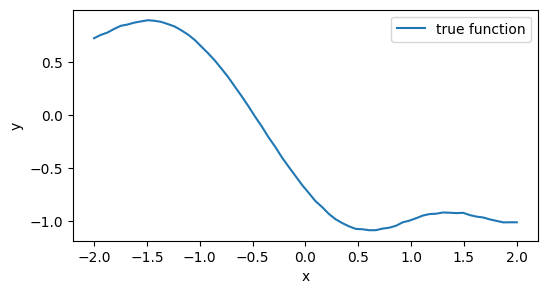

In [42]:
# generate some sample data

key = random.PRNGKey(0)

key, subkey = random.split(key)

x, y = sample_gp(
    key=subkey,
    n_imgs=1,
    domain=2,
    grid_steps=64,
    rho=1.0,
    sigma=2.0
)

print(x.shape, y.shape)

x_plot, y_plot = jnp.squeeze(x), jnp.squeeze(y)

# plot sample data

fig, ax = plt.subplots(figsize=(6, 3))

ax.plot(x_plot, y_plot, label='true function')
ax.set_xlabel('x')
ax.set_ylabel('y')

ax.legend()
plt.show()

(1, 8, 1) (1, 8, 1)


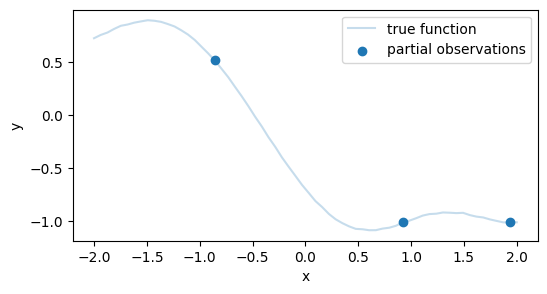

In [43]:
# select partial (context) observations of function

n_context = 8

key, subkey = random.split(key)

x_context = choose_values(
    key=subkey,
    arr=x,
    n=n_context,
)
y_context = choose_values(
    key=subkey,
    arr=y,
    n=n_context,
)

print(x_context.shape, y_context.shape)

# plot context data

fig, ax = plt.subplots(figsize=(6, 3))

ax.plot(x_plot, y_plot, alpha=0.25, label='true function')
ax.scatter(x_context[0, :3, 0], y_context[0, :3, 0], label='partial observations')
ax.set_xlabel('x')
ax.set_ylabel('y')

ax.legend()
plt.show()

In [44]:
key, *subkeys = random.split(key, 3)

encoder = ConvNet([2, 128], subkeys[0])
decoder = ConvNet([129, 2], subkeys[1])

model = CNP(encoder, decoder)

model = eqx.tree_deserialise_leaves('./trained-models/model.eqx', model)

print(model)

CNP(
  layers=[
    ConvNet(
      linear_1=Linear(
        weight=f32[64,2],
        bias=f32[64],
        in_features=2,
        out_features=64,
        use_bias=True
      ),
      linear_2=Linear(
        weight=f32[128,448],
        bias=f32[128],
        in_features=448,
        out_features=128,
        use_bias=True
      ),
      linear_3=Linear(
        weight=f32[128,128],
        bias=f32[128],
        in_features=128,
        out_features=128,
        use_bias=True
      ),
      conv_1=Conv(
        num_spatial_dims=1,
        weight=f32[16,1,3],
        bias=f32[16,1],
        in_channels=1,
        out_channels=16,
        kernel_size=(3,),
        stride=(1,),
        padding=((0, 0),),
        dilation=(1,),
        groups=1,
        use_bias=True,
        padding_mode='ZEROS'
      ),
      conv_2=Conv(
        num_spatial_dims=1,
        weight=f32[32,16,3],
        bias=f32[32,1],
        in_channels=16,
        out_channels=32,
        kernel_size=(3,),
        s

In [45]:
y_preds = model(
    x_context=x_context[:, :3, :],
    y_context=y_context[:, :3, :],
    x_target=x,
)

y_mu = jnp.squeeze(y_preds.mean)
y_sigma = jnp.squeeze(jnp.sqrt(y_preds.variance))

(16, 62)
(16, 31)
(32, 29)
(32, 14)
(448,)
(16, 62)
(16, 31)
(32, 29)
(32, 14)
(448,)


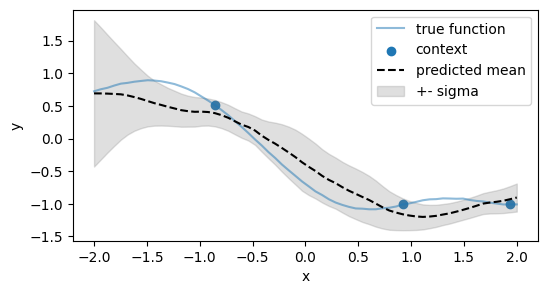

In [46]:
fig, ax = plt.subplots(figsize=(6, 3))

ax.plot(x_plot, y_plot, alpha=0.5, label='true function')
ax.scatter(x_context[0, :3, 0], y_context[0, :3, 0], label='context')
ax.plot(x_plot, y_mu, c='k', ls='--', label='predicted mean')
ax.fill_between(x_plot, y_mu - y_sigma, y_mu + y_sigma, color='grey', alpha=0.25, label="+- sigma")
ax.set_xlabel('x')
ax.set_ylabel('y')

ax.legend()
plt.show()

(16, 62)
(16, 31)
(32, 29)
(32, 14)
(448,)
(16, 62)
(16, 31)
(32, 29)
(32, 14)
(448,)


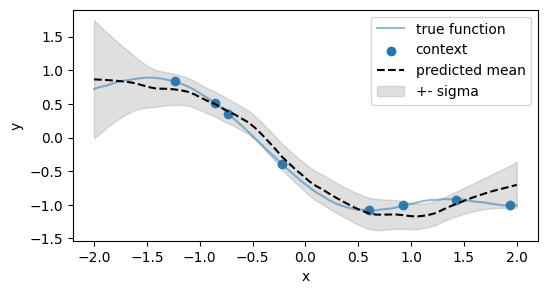

In [47]:
y_preds = model(
    x_context=x_context,
    y_context=y_context,
    x_target=x,
)

y_mu = jnp.squeeze(y_preds.mean)
y_sigma = jnp.squeeze(jnp.sqrt(y_preds.variance))

fig, ax = plt.subplots(figsize=(6, 3))

ax.plot(x_plot, y_plot, alpha=0.5, label='true function')
ax.scatter(x_context[0, :, 0], y_context[0, :, 0], label='context')
ax.plot(x_plot, y_mu, c='k', ls='--', label='predicted mean')
ax.fill_between(x_plot, y_mu - y_sigma, y_mu + y_sigma, color='grey', alpha=0.25, label="+- sigma")
ax.set_xlabel('x')
ax.set_ylabel('y')

ax.legend()
plt.show()

(16, 62)
(16, 31)
(32, 29)
(32, 14)
(448,)
(16, 62)
(16, 31)
(32, 29)
(32, 14)
(448,)


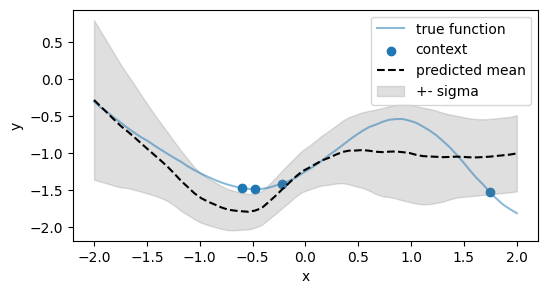

In [48]:
key, subkey = random.split(key)

x, y = sample_gp(
    key=subkey,
    n_imgs=1,
    domain=2,
    grid_steps=64,
    rho=1.0,
    sigma=2.0
)

x_plot, y_plot = jnp.squeeze(x), jnp.squeeze(y)

n_context = 4

key, subkey = random.split(key)

x_context = choose_values(
    key=subkey,
    arr=x,
    n=n_context,
)
y_context = choose_values(
    key=subkey,
    arr=y,
    n=n_context,
)

y_preds = model(
    x_context=x_context,
    y_context=y_context,
    x_target=x,
)

y_mu = jnp.squeeze(y_preds.mean)
y_sigma = jnp.squeeze(jnp.sqrt(y_preds.variance))

fig, ax = plt.subplots(figsize=(6, 3))

ax.plot(x_plot, y_plot, alpha=0.5, label='true function')
ax.scatter(x_context[0, :, 0], y_context[0, :, 0], label='context')
ax.plot(x_plot, y_mu, c='k', ls='--', label='predicted mean')
ax.fill_between(x_plot, y_mu - y_sigma, y_mu + y_sigma, color='grey', alpha=0.25, label="+- sigma")
ax.set_xlabel('x')
ax.set_ylabel('y')

ax.legend()
plt.show()

In [49]:
N_FUNCTIONS = 128
N_POINTS = 64
RHO = 1.0
SIGMA = 2.0
DOMAIN = 2
NORM_SCALE = 4

SPLIT = 0.8
BATCH_SIZE = 16
N_CONTEXT = 16
N_TARGET = 32

ENCODER_DIM = 128  # latent dimension of the encoder
ENCODER_LAYERS = [2, ENCODER_DIM, ENCODER_DIM, ENCODER_DIM]  # number of neurons in each fully-connected layer
DECODER_LAYERS = [ENCODER_DIM + 1, ENCODER_DIM, ENCODER_DIM, ENCODER_DIM, 2]  # number of neurons in each fully-connected layer
LEARNING_RATE = 3e-4
EPOCHS = 2000
PLOT_EVERY = int(10)  # plot progress during training every PRINT_EVERY epochs

SEED = 5678
key = random.PRNGKey(SEED)

In [262]:
key, subkey = random.split(key, 2)
x, y = sample_gp(
    key=subkey,
    n_imgs=N_FUNCTIONS,
    domain=DOMAIN,
    grid_steps=N_POINTS,
    rho=RHO,
    sigma=SIGMA,
)

print(x.shape, y.shape)

(128, 64, 1) (128, 64, 1)


In [263]:
y_norm, _, _ = normalize(y, NORM_SCALE)

In [264]:
lengths = fractions_to_lengths([SPLIT, 1 - SPLIT], N_FUNCTIONS)

train_set, test_set = random_split(datasets=(x, y_norm), lengths=lengths, seed=42)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, seed=42)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True, seed=42)

(Array([[[-2.       ],
        [-1.9365079],
        [-1.8730159],
        ...,
        [ 1.8730161],
        [ 1.9365082],
        [ 2.       ]],

       [[-2.       ],
        [-1.9365079],
        [-1.8730159],
        ...,
        [ 1.8730161],
        [ 1.9365082],
        [ 2.       ]],

       [[-2.       ],
        [-1.9365079],
        [-1.8730159],
        ...,
        [ 1.8730161],
        [ 1.9365082],
        [ 2.       ]],

       ...,

       [[-2.       ],
        [-1.9365079],
        [-1.8730159],
        ...,
        [ 1.8730161],
        [ 1.9365082],
        [ 2.       ]],

       [[-2.       ],
        [-1.9365079],
        [-1.8730159],
        ...,
        [ 1.8730161],
        [ 1.9365082],
        [ 2.       ]],

       [[-2.       ],
        [-1.9365079],
        [-1.8730159],
        ...,
        [ 1.8730161],
        [ 1.9365082],
        [ 2.       ]]], dtype=float32), Array([[[-0.39242625],
        [-0.4520192 ],
        [-0.50903916],
        ...,
      

In [287]:
dummy_x, dummy_y = next(iter(train_loader))

print(dummy_x.shape, dummy_y.shape)

print(len(train_loader))

(16, 64, 1) (16, 64, 1)
7


In [266]:
key, *subkeys = random.split(key, 3)
# encoder = MLP(ENCODER_LAYERS, subkeys[0])
# decoder = MLP(DECODER_LAYERS, subkeys[1])
encoder = ConvNet([2, 128], subkeys[0])
decoder = ConvNet([129, 2], subkeys[1])

model = CNP(encoder, decoder)

print(model)

CNP(
  layers=[
    ConvNet(
      linear_1=Linear(
        weight=f32[64,2],
        bias=f32[64],
        in_features=2,
        out_features=64,
        use_bias=True
      ),
      linear_2=Linear(
        weight=f32[128,448],
        bias=f32[128],
        in_features=448,
        out_features=128,
        use_bias=True
      ),
      linear_3=Linear(
        weight=f32[128,128],
        bias=f32[128],
        in_features=128,
        out_features=128,
        use_bias=True
      ),
      conv_1=Conv(
        num_spatial_dims=1,
        weight=f32[16,1,3],
        bias=f32[16,1],
        in_channels=1,
        out_channels=16,
        kernel_size=(3,),
        stride=(1,),
        padding=((0, 0),),
        dilation=(1,),
        groups=1,
        use_bias=True,
        padding_mode='ZEROS'
      ),
      conv_2=Conv(
        num_spatial_dims=1,
        weight=f32[32,16,3],
        bias=f32[32,1],
        in_channels=16,
        out_channels=32,
        kernel_size=(3,),
        s

In [267]:
optim = optax.adamw(LEARNING_RATE)

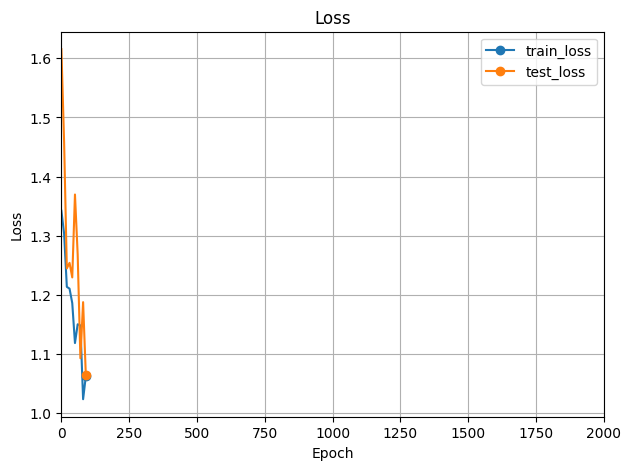

KeyboardInterrupt: 

In [268]:
key, subkey = random.split(key, 2)

model = train(
    key,
    model,
    train_loader,
    test_loader,
    optim,
    N_CONTEXT,
    N_TARGET,
    EPOCHS,
    PLOT_EVERY,
)

In [ ]:
# eqx.tree_serialise_leaves('./trained-models/model', model)

In [ ]:
model = CNP(encoder, decoder)

model = eqx.tree_deserialise_leaves('./trained-models/model.eqx', model)

print(model)

CNP(
  layers=[
    ConvNet(
      linear_1=Linear(
        weight=f32[64,2],
        bias=f32[64],
        in_features=2,
        out_features=64,
        use_bias=True
      ),
      linear_2=Linear(
        weight=f32[128,448],
        bias=f32[128],
        in_features=448,
        out_features=128,
        use_bias=True
      ),
      linear_3=Linear(
        weight=f32[128,128],
        bias=f32[128],
        in_features=128,
        out_features=128,
        use_bias=True
      ),
      conv_1=Conv(
        num_spatial_dims=1,
        weight=f32[16,1,3],
        bias=f32[16,1],
        in_channels=1,
        out_channels=16,
        kernel_size=(3,),
        stride=(1,),
        padding=((0, 0),),
        dilation=(1,),
        groups=1,
        use_bias=True,
        padding_mode='ZEROS'
      ),
      conv_2=Conv(
        num_spatial_dims=1,
        weight=f32[32,16,3],
        bias=f32[32,1],
        in_channels=16,
        out_channels=32,
        kernel_size=(3,),
        s

In [ ]:
key, subkey = random.split(key, 2)
x_test, y_test = sample_gp(subkey, 1, DOMAIN, N_POINTS, 1.0, 2.0)

# y_test_norm, min_val, max_val = normalize(y_test, NORM_SCALE)

key, *subkeys = random.split(key, 3)
x_test_context, y_test_context, _, _ = split_data(subkeys, x_test, y_test, 4, N_POINTS)

In [ ]:
y_preds = model(x_test_context, y_test_context, x_test)

# y_mu = unnormalize(jnp.squeeze(y_preds.mean), min_val, max_val, NORM_SCALE)
# y_sigma = unnormalize_std(jnp.squeeze(jnp.sqrt(y_preds.variance)), min_val, max_val, NORM_SCALE)

y_mu = jnp.squeeze(y_preds.mean)
y_sigma = jnp.squeeze(jnp.sqrt(y_preds.variance))

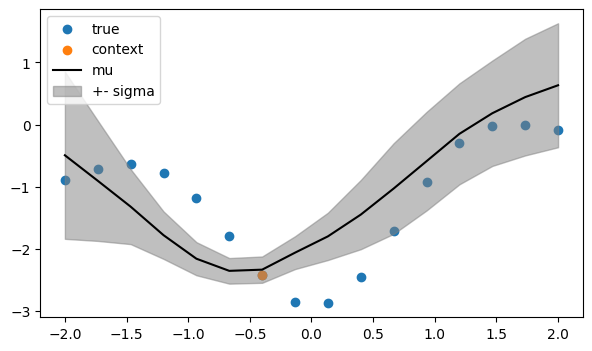

In [ ]:
x_plot = np.squeeze(x_test)

fig, ax = plt.subplots(figsize=(7, 4))

ax.scatter(x_plot, jnp.squeeze(y_test), label="true")
# ax.scatter(x_test_context, unnormalize(y_test_context_norm, min_val, max_val, NORM_SCALE), label="context")
ax.scatter(x_test_context, y_test_context, label="context")
ax.plot(x_plot, y_mu, c='k', label='mu')
ax.fill_between(x_plot, y_mu - y_sigma, y_mu + y_sigma, color='grey', alpha=0.5, label="+- sigma")

ax.legend()

plt.show()